In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import os
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter


In [ ]:
# Set the path to preprocessed data folder
preprocessed_folder = '/content/drive/MyDrive/fyp1/preprocessed_data'

In [ ]:
# Create a DataFrame to store image paths and labels
image_paths = []
labels = []

for class_name in os.listdir(preprocessed_folder):
    class_path = os.path.join(preprocessed_folder, class_name)

    # Iterate through images in each class
    for image_name in os.listdir(class_path):
        image_path = os.path.join(class_path, image_name)

        # Append image path and label to lists
        image_paths.append(image_path)
        labels.append(class_name)

In [ ]:
# Create a DataFrame with image paths and labels
df = pd.DataFrame({'image_path': image_paths, 'label': labels})

In [ ]:
# Split the data into training and testing sets
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)


In [ ]:
# Define image size and batch size
image_size = (224, 224)
batch_size = 32


In [ ]:
# Create an ImageDataGenerator for data augmentation and normalization
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

test_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
# Create flow_from_dataframe generators
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='image_path',
    y_col='label',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical'
)

# Print the shape of a batch of images
for images, labels in train_generator:
    print("Shape of images batch:", images.shape)
    print("Shape of labels batch:", labels.shape)
    break

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='image_path',
    y_col='label',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical'
)


Found 332 validated image filenames belonging to 4 classes.
Shape of images batch: (32, 224, 224, 3)
Shape of labels batch: (32, 4)
Found 84 validated image filenames belonging to 4 classes.


In [ ]:
#  CNN model
base_model = tf.keras.applications.MobileNetV2(input_shape=(224,224,3),
                                               include_top=False,
                                               weights='imagenet')
base_model.trainable = False

9406464/9406464 [==============================] - 0s 0us/step


In [ ]:
image_batch, label_batch = next(iter(train_generator))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 7, 7, 1280)


In [ ]:
base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 112, 112, 32)         864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 112, 112, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 112, 112, 32)         0         ['bn_Conv1[

In [ ]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

prediction_layer = tf.keras.layers.Dense(4, activation='softmax')
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1280)
(32, 4)


In [ ]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

In [ ]:
inputs = tf.keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
#x = preprocess_input(x)
x = base_model(x, training=False)
#x = base_model(inputs , training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [ ]:
# Define the path to save the training log file
log_path = '/content/drive/MyDrive/fyp1/Model/logs'
os.makedirs(log_path, exist_ok=True)


# Callbacks
callbacks = [
    tf.keras.callbacks.CSVLogger(log_path + "/training.log", separator=",", append=True),
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=30)
]

# Compile the model with a custom optimizer and learning rate
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=test_generator,
    callbacks=callbacks

)



Epoch 1/10
11/11 [==============================] - 82s 7s/step - loss: 1.8041 - accuracy: 0.2590 - val_loss: 1.4314 - val_accuracy: 0.3452
Epoch 2/10
11/11 [==============================] - 28s 2s/step - loss: 1.6682 - accuracy: 0.2831 - val_loss: 1.3653 - val_accuracy: 0.3690
Epoch 3/10
11/11 [==============================] - 27s 2s/step - loss: 1.5287 - accuracy: 0.3072 - val_loss: 1.3363 - val_accuracy: 0.3571
Epoch 4/10
11/11 [==============================] - 34s 3s/step - loss: 1.4725 - accuracy: 0.3193 - val_loss: 1.3054 - val_accuracy: 0.4167
Epoch 5/10
11/11 [==============================] - 30s 3s/step - loss: 1.4811 - accuracy: 0.3343 - val_loss: 1.2729 - val_accuracy: 0.4167
Epoch 6/10
11/11 [==============================] - 30s 3s/step - loss: 1.4310 - accuracy: 0.3494 - val_loss: 1.2315 - val_accuracy: 0.4524
Epoch 7/10
11/11 [==============================] - 29s 3s/step - loss: 1.4015 - accuracy: 0.3705 - val_loss: 1.1969 - val_accuracy: 0.4286
Epoch 8/10
11/11 [==

In [ ]:
loss0, accuracy0 = model.evaluate(test_generator)

3/3 [==============================] - 6s 2s/step - loss: 1.1300 - accuracy: 0.4405


In [ ]:
base_model.trainable = True

In [ ]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  154


In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, None, None, None   0         
                             )                                   
                                                                 
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                             

In [ ]:
history_fine = model.fit(train_generator,
                         epochs=50,
                         initial_epoch=history.epoch[-1],
                         validation_data=test_generator)

Epoch 10/50
11/11 [==============================] - 53s 4s/step - loss: 1.2941 - accuracy: 0.4488 - val_loss: 1.0406 - val_accuracy: 0.5595
Epoch 11/50
11/11 [==============================] - 40s 3s/step - loss: 1.0431 - accuracy: 0.5452 - val_loss: 0.8478 - val_accuracy: 0.6071
Epoch 12/50
11/11 [==============================] - 35s 3s/step - loss: 0.8297 - accuracy: 0.6687 - val_loss: 0.8419 - val_accuracy: 0.6429
Epoch 13/50
11/11 [==============================] - 34s 3s/step - loss: 0.6610 - accuracy: 0.7289 - val_loss: 0.9643 - val_accuracy: 0.6190
Epoch 14/50
11/11 [==============================] - 35s 3s/step - loss: 0.6464 - accuracy: 0.7410 - val_loss: 0.7778 - val_accuracy: 0.7262
Epoch 15/50
11/11 [==============================] - 38s 3s/step - loss: 0.5893 - accuracy: 0.7530 - val_loss: 0.7337 - val_accuracy: 0.7381
Epoch 16/50
11/11 [==============================] - 35s 3s/step - loss: 0.5097 - accuracy: 0.7831 - val_loss: 0.5832 - val_accuracy: 0.7619
Epoch 17/50
1

In [ ]:

# Define the path to save the model
save_path = '/content/drive/MyDrive/fyp1/Model'

# Check if the directory exists, if not, create it
if not os.path.exists(save_path):
    os.makedirs(save_path)

# Save the model
tf.saved_model.save(model, save_path)

print("Model saved successfully at:", save_path)
# model.save('/content/drive/MyDrive/fyp1/Model/model1.h5')

model.save('/content/drive/MyDrive/fyp1/Model/OurModel.keras')

Model saved successfully at: /content/drive/MyDrive/fyp1/Model


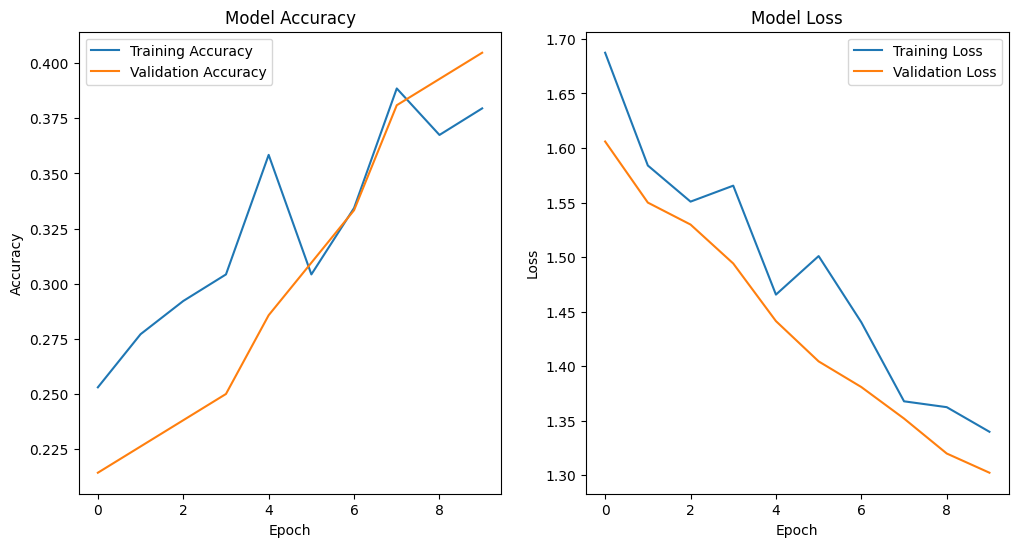

In [ ]:
# Plot the training and validation accuracy over epochs
plt.figure(figsize=(12, 6))

# Plot the training and validation accuracy over epochs
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

In [ ]:
import pandas as pd
from PIL import Image
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report
from collections import Counter
from keras.models import load_model

# Load CSV containing test image paths and labels
test_csv_path = '/content/drive/MyDrive/fyp1/Dataset/test_dataset_folder/test_dataset.csv'
test_df = pd.read_csv(test_csv_path)

# Define label encoding for the four labels
label_encoder = LabelEncoder()
label_encoder.fit(['Metal', 'Foam', 'Plastic', 'Glass'])

# Transform the labels in the test dataset
test_df['label'] = label_encoder.transform(test_df['label'])

# Preprocess test images
def preprocess_image(image_path, target_size):
    image = Image.open(image_path)
    image = image.resize(target_size)
    image = np.array(image) / 255.0  # Normalize pixel values
    return image

test_images = [preprocess_image(image_path, (224, 224)) for image_path in test_df['image_path']]
test_labels = test_df['label'].values

# Convert list of images to numpy array
test_images = np.array(test_images)

model = load_model('/content/drive/MyDrive/fyp1/Model/model1.h5')

# Perform predictions
predictions = model.predict(test_images)

# Convert predictions to class labels
predicted_labels = label_encoder.inverse_transform(np.argmax(predictions, axis=1))

# Print actual and predicted waste types
for image_path, actual_label, predicted_label in zip(test_df['image_path'], label_encoder.inverse_transform(test_df['label']), predicted_labels):
    print(f"Image: {image_path}, Actual Label: {actual_label}, Predicted Label: {predicted_label}")

# Count the occurrences of each predicted label
predicted_label_counts = Counter(predicted_labels)

# Total number of predictions
total_predictions = len(predicted_labels)
print("Total predictions:", total_predictions)

# Calculate the percentage of each class
class_percentages = {label: (count, count / total_predictions * 100) for label, count in predicted_label_counts.items()}

# Print the percentage of each class
#for label, percentage in class_percentages.items():
#    print(f"{label}: {percentage:.2f}%")


# Print the count and percentage of each class
for label, (count, percentage) in class_percentages.items():
    print(f"{label}: Count: {count}, Percentage: {percentage:.2f}%")

# Calculate accuracy
accuracy = accuracy_score(test_df['label'], np.argmax(predictions, axis=1))
print("Accuracy:", accuracy)

# Generate classification report
report = classification_report(test_df['label'], np.argmax(predictions, axis=1), target_names=label_encoder.classes_)
print("Classification Report:")
print(report)


9/9 [==============================] - 1s 44ms/step
Image: /content/drive/MyDrive/FYP/Dataset/Dataset1/Metal/CD_276198_jpg.rf.a130f8c82679a875220c6f22f268cde6.jpg, Actual Label: Metal, Predicted Label: Metal
Image: /content/drive/MyDrive/FYP/Dataset/Dataset1/Plastic/CD_274414_jpg.rf.a2d6513d65a75aa1693f243228a94dcf.jpg, Actual Label: Plastic, Predicted Label: Plastic
Image: /content/drive/MyDrive/FYP/Dataset/Dataset1/Glass/CD_365_jpg.rf.a66e09e0ec8ae6b649d80b6160f7d4fa.jpg, Actual Label: Glass, Predicted Label: Glass
Image: /content/drive/MyDrive/FYP/Dataset/Dataset1/Plastic/CD_272953_jpg.rf.99549e860dff3d9103061fd47c76b2b6.jpg, Actual Label: Plastic, Predicted Label: Plastic
Image: /content/drive/MyDrive/FYP/Dataset/Dataset1/Plastic/003450.jpg, Actual Label: Plastic, Predicted Label: Plastic
Image: /content/drive/MyDrive/FYP/Dataset/Dataset1/Foam/CD_9766_jpg.rf.f2a0ef75bd14e5c03550db1a7ce051c5.jpg, Actual Label: Foam, Predicted Label: Plastic
Image: /content/drive/MyDrive/FYP/Dataset/

In [ ]:
from PIL import Image
import numpy as np
from collections import Counter
from keras.models import load_model

def predict_labels(image_paths, model_path, target_size=(224, 224)):
    # Load the trained model
    model = load_model('/content/drive/MyDrive/fyp1/Model/model1.h5')

    # Preprocess images
    def preprocess_image(image_path, target_size):
        image = Image.open(image_path)
        image = image.resize(target_size)
        image = np.array(image) / 255.0  # Normalize pixel values
        return image

    # Preprocess test images
    test_images = [preprocess_image(image_path, target_size) for image_path in image_paths]

    # Convert list of images to numpy array
    test_images = np.array(test_images)

    # Perform predictions
    predictions = model.predict(test_images)

    # Get predicted labels
    predicted_labels = np.argmax(predictions, axis=1)

    # Count the occurrences of each predicted label
    predicted_label_counts = Counter(predicted_labels)

    # Total number of predictions
    total_predictions = len(predicted_labels)
    print("Total predictions:", total_predictions)

    # Print the count and percentage of each class
    for label, percentage in class_percentages.items():
        print(f"Predicted Label: {label}, Percentage: {percentage:.2f}%, Count: {predicted_label_counts[label]}")

    # Print the count and percentage of each actual label
    for label, count in actual_label_counts.items():
        print(f"Actual Label: {label}, Count: {count}")

# List of image paths
image_paths = [
    '/content/drive/MyDrive/fyp1/Dataset/testdata/plastic3.jpg',
    '/content/drive/MyDrive/fyp1/Dataset/testdata/plastic2.jpg',
    '/content/drive/MyDrive/fyp1/Dataset/testdata/metal3.jpg',
    '/content/drive/MyDrive/fyp1/Dataset/testdata/metal2.jpg',
    '/content/drive/MyDrive/fyp1/Dataset/testdata/glass3.jpg',
    '/content/drive/MyDrive/fyp1/Dataset/testdata/glass2.jpg',
    '/content/drive/MyDrive/fyp1/Dataset/testdata/foam3.jpg',
    '/content/drive/MyDrive/fyp1/Dataset/testdata/foam1.png',


    # Add more image paths here as needed
]

# Actual labels corresponding to the images
actual_labels = ['plastic', 'plastic', 'metal', 'metal', 'glass', 'glass', 'foam', 'foam']

# Path to the trained model
model_path = '/content/drive/MyDrive/fyp1/Model/model1.h5'

# Call the function to predict labels and print percentages
predict_labels(image_paths, model_path, actual_labels)


TypeError: argument 1 must be sequence of length 2, not 8

In [ ]:
from PIL import Image
import numpy as np
from collections import Counter
from keras.models import load_model
from sklearn.preprocessing import LabelEncoder

def predict_labels(image_paths, model_path, actual_labels=None, target_size=(224, 224)):
    # Load the trained model
    model = load_model(model_path)

    # Preprocess images
    def preprocess_image(image_path, target_size):
        image = Image.open(image_path)
        image = image.resize(target_size)
        image = np.array(image) / 255.0  # Normalize pixel values
        return image

    # Preprocess test images
    test_images = [preprocess_image(image_path, target_size) for image_path in image_paths]

    # Convert list of images to numpy array
    test_images = np.array(test_images)

    # Perform predictions
    predictions = model.predict(test_images)

    # Get predicted labels
    predicted_labels = np.argmax(predictions, axis=1)

    # Count the occurrences of each predicted label
    predicted_label_counts = Counter(predicted_labels)

    # Total number of predictions
    total_predictions = len(predicted_labels)
    print("Total predictions:", total_predictions)

    # Calculate the percentage of each predicted class
    class_percentages = {label: count / total_predictions * 100 for label, count in predicted_label_counts.items()}

    # Print the count and percentage of each predicted class
    for label, percentage in class_percentages.items():
        print(f"Predicted Label: {label}, Percentage: {percentage:.2f}%, Count: {predicted_label_counts[label]}")

    # If actual labels are provided, calculate and print the count and percentage of each actual class
    if actual_labels:
        label_encoder = LabelEncoder()
        actual_labels_encoded = label_encoder.fit_transform(actual_labels)
        actual_label_counts = Counter(actual_labels_encoded)
        print("\nActual Label Counts:")
        for label, count in actual_label_counts.items():
            print(f"Actual Label: {label}, Count: {count}")

# Example usage:

# List of image paths
image_paths = [
    '/content/drive/MyDrive/fyp1/Dataset/testdata/plastic3.jpg',
    '/content/drive/MyDrive/fyp1/Dataset/testdata/plastic2.jpg',
    '/content/drive/MyDrive/fyp1/Dataset/testdata/metal3.jpg',
    '/content/drive/MyDrive/fyp1/Dataset/testdata/metal2.jpg',
    '/content/drive/MyDrive/fyp1/Dataset/testdata/glass3.jpg',
    '/content/drive/MyDrive/fyp1/Dataset/testdata/glass2.jpg',
    '/content/drive/MyDrive/fyp1/Dataset/testdata/foam3.jpg',
    '/content/drive/MyDrive/fyp1/Dataset/testdata/foam1.png',
    # Add more image paths here as needed
]

# Actual labels corresponding to the images (if available)
actual_labels = ['plastic', 'plastic', 'metal', 'metal', 'glass', 'glass', 'foam', 'foam']

# Path to the trained model
model_path = '/content/drive/MyDrive/fyp1/Model/model1.h5'

# Call the function to predict labels and print percentages
predict_labels(image_paths, model_path, actual_labels)


1/1 [==============================] - 2s 2s/step
Total predictions: 8
Predicted Label: 2, Percentage: 37.50%, Count: 3
Predicted Label: 3, Percentage: 12.50%, Count: 1
Predicted Label: 1, Percentage: 25.00%, Count: 2
Predicted Label: 0, Percentage: 25.00%, Count: 2

Actual Label Counts:
Actual Label: 3, Count: 2
Actual Label: 2, Count: 2
Actual Label: 1, Count: 2
Actual Label: 0, Count: 2


In [ ]:
from PIL import Image
import numpy as np
from collections import Counter
from keras.models import load_model
from sklearn.preprocessing import LabelEncoder

def predict_labels(image_paths, model_path, actual_labels=None, target_size=(224, 224)):
    # Load the trained model
    model = load_model(model_path)

    # Preprocess images
    def preprocess_image(image_path, target_size):
        image = Image.open(image_path)
        image = image.resize(target_size)
        image = np.array(image) / 255.0  # Normalize pixel values
        return image

    # Preprocess test images
    test_images = [preprocess_image(image_path, target_size) for image_path in image_paths]

    # Convert list of images to numpy array
    test_images = np.array(test_images)

    # Perform predictions
    predictions = model.predict(test_images)

    # Get predicted labels
    predicted_labels = np.argmax(predictions, axis=1)

    # Count the occurrences of each predicted label
    predicted_label_counts = Counter(predicted_labels)

    # Total number of predictions
    total_predictions = len(predicted_labels)
    print("Total predictions:", total_predictions)

    # Calculate the percentage of each predicted class
    class_percentages = {label: count / total_predictions * 100 for label, count in predicted_label_counts.items()}

    # Load the label encoder
    label_encoder = LabelEncoder()

    # If actual labels are provided, encode them and calculate their counts
    if actual_labels:
        actual_labels_encoded = label_encoder.fit_transform(actual_labels)
        actual_label_counts = Counter(actual_labels_encoded)
        print("\nActual Label Counts:")
        for label, count in actual_label_counts.items():
            print(f"Actual Label: {label}, Count: {count}")

    # Print the count and percentage of each predicted class along with the class name
    print("\nPredicted Label Counts:")
    for label, percentage in class_percentages.items():
        class_name = label_encoder.inverse_transform([label])[0]
        print(f"Predicted Label: {label} ({class_name}), Percentage: {percentage:.2f}%, Count: {predicted_label_counts[label]}")

# Example usage:

# List of image paths
image_paths = [
    '/content/drive/MyDrive/fyp1/Dataset/testdata/plastic3.jpg',
    '/content/drive/MyDrive/fyp1/Dataset/testdata/plastic2.jpg',
    '/content/drive/MyDrive/fyp1/Dataset/testdata/metal3.jpg',
    '/content/drive/MyDrive/fyp1/Dataset/testdata/metal2.jpg',
    '/content/drive/MyDrive/fyp1/Dataset/testdata/glass3.jpg',
    '/content/drive/MyDrive/fyp1/Dataset/testdata/glass2.jpg',
    '/content/drive/MyDrive/fyp1/Dataset/testdata/foam3.jpg',
    '/content/drive/MyDrive/fyp1/Dataset/testdata/foam1.png',
    # Add more image paths here as needed
]

# Actual labels corresponding to the images (if available)
actual_labels = ['plastic', 'plastic', 'metal', 'metal', 'glass', 'glass', 'foam', 'foam']

# Path to the trained model
model_path = '/content/drive/MyDrive/fyp1/Model/model1.h5'

# Call the function to predict labels and print percentages
predict_labels(image_paths, model_path, actual_labels)


1/1 [==============================] - 1s 1s/step
Total predictions: 8

Actual Label Counts:
Actual Label: 3, Count: 2
Actual Label: 2, Count: 2
Actual Label: 1, Count: 2
Actual Label: 0, Count: 2

Predicted Label Counts:
Predicted Label: 2 (metal), Percentage: 37.50%, Count: 3
Predicted Label: 3 (plastic), Percentage: 12.50%, Count: 1
Predicted Label: 1 (glass), Percentage: 25.00%, Count: 2
Predicted Label: 0 (foam), Percentage: 25.00%, Count: 2
